With this notebook we want to test how many and which of the important features have been exploited by each isolation tree in a given isolation forest.

In [1]:
import os
import numpy as np
import pickle as pkl 
import time
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.utils import shuffle
import shap
import diffi.interpretability_module as interp
from diffi.utils import *

/Users/sebastianosanson/Documents/Master Thesis/Master-Thesis/mt_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
with open(os.path.join(os.getcwd(), 'dataset', 'syn_train.pkl'), 'rb') as f:
    data_tr = pkl.load(f)
with open(os.path.join(os.getcwd(), 'dataset', 'syn_test.pkl'), 'rb') as f:
    data_te = pkl.load(f)

X_tr = data_tr.iloc[:, :-1]
y_tr = data_tr.iloc[:, -1]

X_tr, y_tr = shuffle(X_tr, y_tr, random_state=0)

X_te = data_te.iloc[:, :-1]
y_te = data_te.iloc[:, -1]


In [3]:
print('Training set size: ', X_tr.shape)
print('Test set size: ', X_te.shape)

print('Trainin label size: ', y_tr.shape)
print('Test label size: ', y_te.shape)

Training set size:  (1000, 20)
Test set size:  (100, 20)
Trainin label size:  (1000,)
Test label size:  (100,)


## Train the Isolation Forest

In [4]:
iforest = IsolationForest(n_estimators=100, max_samples=256, contamination=0.1, random_state=0, bootstrap=False)
iforest.fit(X_tr)
y_tr_pred = np.array(iforest.decision_function(X_tr) < 0).astype(int)    # > 0 -> True -> 1; < 0 -> False -> 0
f1 = f1_score(y_tr, y_tr_pred)
print('F1 score on training data: {:.4f}'.format(f1))

F1 score on training data: 0.4300


In [5]:
y_te_pred = np.array(iforest.decision_function(X_te) < 0).astype(int)    
print('Detected anomalies: {} out of {}'.format(int(sum(y_te_pred)), len(y_te)))

Detected anomalies: 50 out of 100


This cell prints the features ranking, computed by global DIFFI.

In [6]:
sorted_idx, avg_f1 = diffi_ranks(X=X_tr.to_numpy(), y=y_tr.to_numpy(), n_trees=100, max_samples=256, n_iter=10, contamination=0.1)
print('Average F1 score: {:.4f}'.format(avg_f1))
print('Ranked features: ', sorted_idx)

Average F1 score: 0.4330
Ranked features:  [ 1  0 10 13  3  8 15  9 17  4 11  7 18 16 19 14  6 12  5  2]


Notice that the two most important features are the meaningful ones, while the other are the noise ones (in according to synthetic dataset).

In [7]:
two_most_important_features = sorted_idx[:2]
print('Two most important features:', two_most_important_features)

Two most important features: [1 0]


Now we want to check how many times each tree has used these two meaningful features

In [8]:
# for i, tree in enumerate(iforest.estimators_):
    # print(f"Tree {i}:")
    # print(f"  Depth: {tree.tree_.max_depth}")
    # print(f"  Number of nodes: {tree.tree_.node_count}")

    # features_per_tree.append(tree.tree_.feature)
    # print(f"  Features used: {tree.tree_.feature}")    

features_per_tree = [tree.tree_.feature for _, tree in enumerate(iforest.estimators_)]
# print('Features per tree:', features_per_tree)

In [9]:
# num_features_per_tree = [len(tree_features) for tree_features in features_per_tree]
# print('Number of features used by each tree:', num_features_per_tree)

**TO-DO**:
- capire che statistiche tirare fuori da `features_per_tree`:
    * percentuale d'uso delle features nell'isolation forest -> osservarne il trend riguardante l'uso delle `k` feature più importanti rispetto alle altre (queste feature sono le stesse che serviranno per effettuare gli *isolation split*)
    * quante volte sono state utilizzate le `two_most_important_features` in ciascun isolation tree (percentuale di utilizzo)
        * calcolare la media della percentuale di utilizzo delle `two_most_important_features`
            * contare gli isolation tree con percentuale di utilizzo delle `two_most_important_features` > della media
    * altro?
- capire/chiedere il motivo per cui le performance sono basse e di conseguenza se il dataset sintetico creato è idoneo
- altro?

## Global features usage in Isolation Forest

We compute the usage of each feature over the Isolation Forest

20


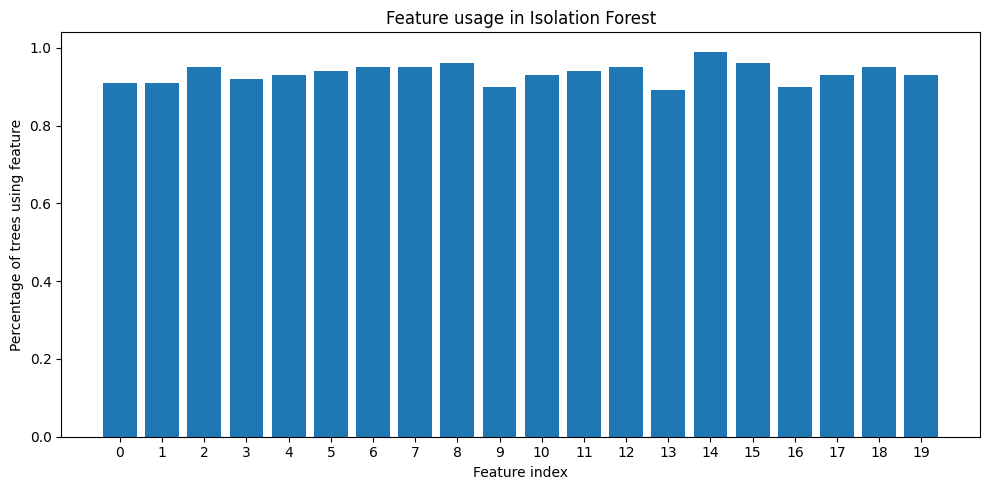

In [ ]:
usage = []
print(X_tr.shape[1])
for i in range(X_tr.shape[1]):   # for each features
    count = 0
    for j in range(len(features_per_tree)):     # for each trees
        if i in features_per_tree[j]:
            count += 1
    usage.append(count / len(features_per_tree))
usage = np.array(usage)

plt.figure(figsize=(10, 5))
plt.bar(range(X_tr.shape[1]), usage)
plt.xlabel('Feature index')
plt.ylabel('Percentage of trees using feature')
plt.title('Feature usage in Isolation Forest')
plt.xticks(range(X_tr.shape[1]))
plt.tight_layout()
plt.show()


## `two_most_important_features` usage 

Counting how many times the `two_most_important_features`are used in each Isolation Tree

In [11]:
two_most_important_features_usage = np.zeros((len(two_most_important_features), len(features_per_tree)))
# print(two_most_important_features_usage.shape)
for i in range(len(two_most_important_features)):
    # print('two_most_important_features[{}]: {}'.format(i+1, two_most_important_features[i]))
    for j in range(len(features_per_tree)):
        count = 0
        # print('len(features_per_tree[{}]): {}'.format(j+1, len(features_per_tree[j])))
        count = sum(1 for k in features_per_tree[j] if k == two_most_important_features[i])
        # print('count feature: {}'.format(count))
        two_most_important_features_usage[i][j] = count / len(features_per_tree[j])

# print('Two most important features usage:', two_most_important_features_usage)


Now we are going to normalize the results to the range [0, 1]

In [12]:
two_most_important_features_usage_probabilities = two_most_important_features_usage / np.max(two_most_important_features_usage, axis=1, keepdims=True)

# print('Two most important features usage probabilities:', two_most_important_features_usage_probabilities)

In [13]:
# tmp = np.zeros(two_most_important_features_usage.shape)

# for i in range(two_most_important_features_usage.shape[0]):
#     max = np.max(two_most_important_features_usage[i])
#     print('max: {}'.format(max))
#     for j in range(two_most_important_features_usage.shape[1]):
#         tmp[i][j] = two_most_important_features_usage[i][j] / max

# print('Two most important features usage (probabilities):', tmp)

Plotting the usage probabilities of `two_most_important_features` across isolation trees

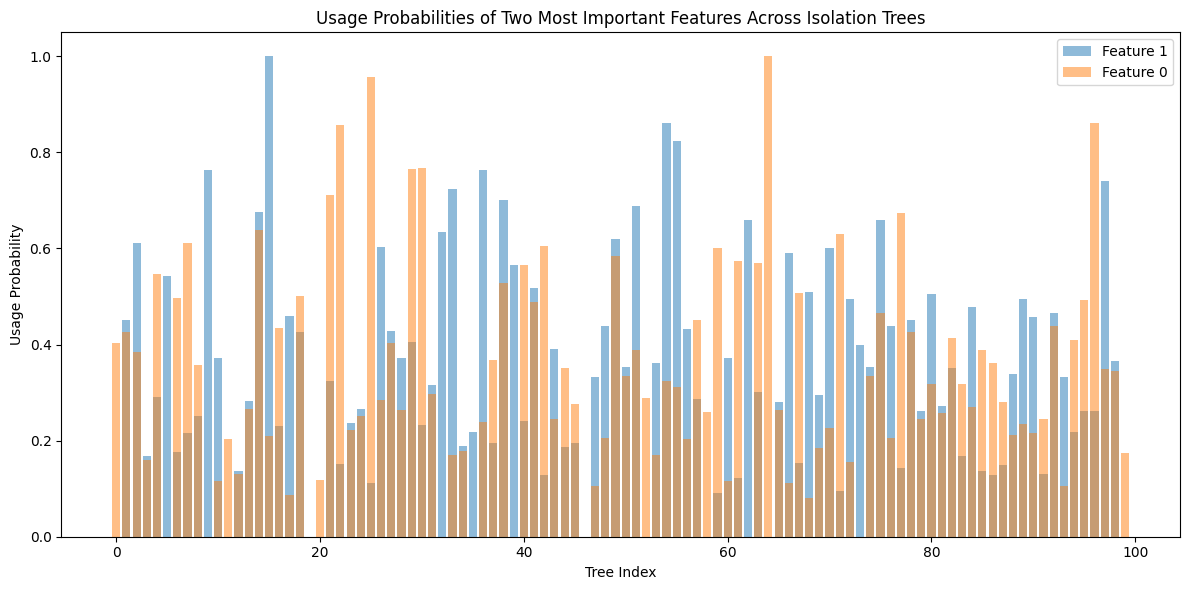

In [24]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(two_most_important_features):
    plt.bar(range(len(two_most_important_features_usage_probabilities[i])), 
            two_most_important_features_usage_probabilities[i], 
            alpha=0.5, label=f'Feature {feature}')
plt.xlabel('Tree Index')
plt.ylabel('Usage Probability')
plt.title('Usage Probabilities of Two Most Important Features Across Isolation Trees')
plt.legend()
plt.tight_layout()
plt.show()

## Average usage

Calculating the average of the `two_most_important_features_usage_probabilities` for each `two_most_important_features`

In [23]:
average_usage_probabilities = np.mean(two_most_important_features_usage_probabilities, axis=1)
for i, feature in enumerate(two_most_important_features):
    print(f"Average usage probability for Feature {feature}: {average_usage_probabilities[i]:.4f}")

Average usage probability for Feature 1: 0.3488
Average usage probability for Feature 0: 0.3358


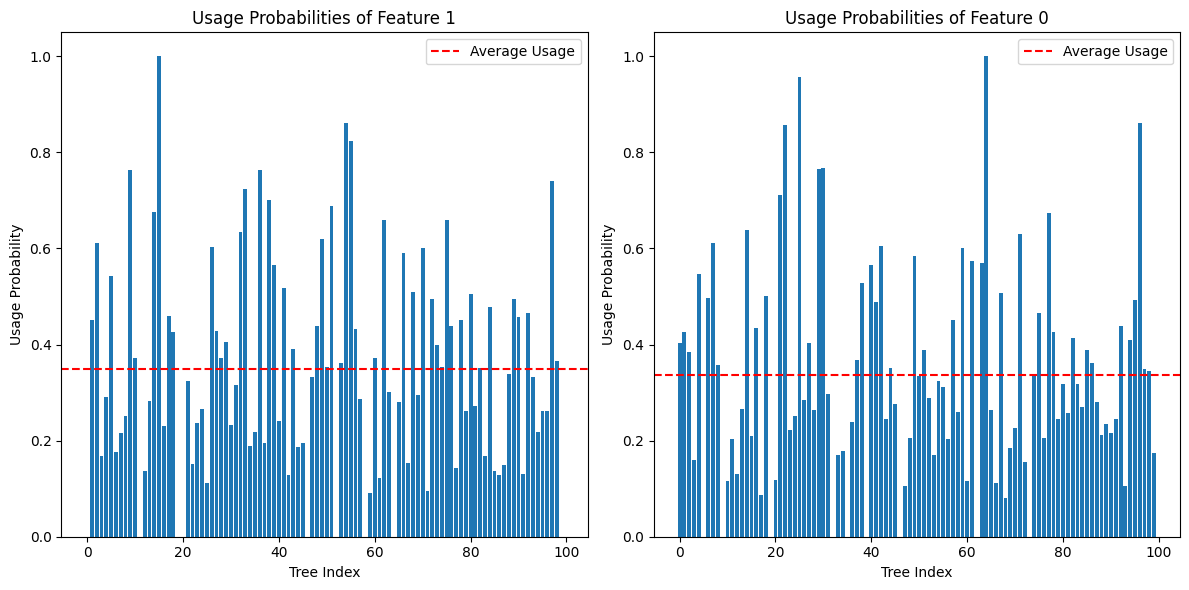

In [34]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(two_most_important_features):
    plt.subplot(1, 2, i+1)
    plt.bar(range(len(two_most_important_features_usage_probabilities[i])), two_most_important_features_usage_probabilities[i])
    plt.axhline(y=average_usage_probabilities[i], color='r', linestyle='--', label='Average Usage')
    plt.xlabel('Tree Index')
    plt.ylabel('Usage Probability')
    plt.title('Usage Probabilities of Feature {}'.format(feature))
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
trees_above_average = np.sum(two_most_important_features_usage_probabilities > average_usage_probabilities[:, np.newaxis], axis=1)

for i, feature in enumerate(two_most_important_features):
    print(f"Number of trees where Feature {feature} usage > average: {trees_above_average[i]} out of {len(features_per_tree)}")

Number of trees where Feature 1 usage > average: 47 out of 100
Number of trees where Feature 0 usage > average: 43 out of 100
